In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from pymc3 import traceplot

import glam

%load_ext autoreload
%autoreload 2

# Test Case 2: Within-participant design

In the second test case we demonstrate the use of the model for a within-participant design. Here, each participant performs multiple conditions that are hypothesized to affect participants' gaze bias $\gamma$ and general processing speed $v$. There are four conditions in total:

1. High Bias &  Fast Speed
2. High Bias &  Slow Speed
3. Low Bias & Fast Speed
4. Low Bias & Slow Speed

# Simulating data

First, we simulate data of 20 participants, with 50 trials in each condition.

In [11]:
# Set the random seed, so that we can re-create exactly the same data, if we need to
np.random.seed(3)

# Setup up a GLAM model instance whose parameters will later be dependent on the 
# experiment conditions
dependence_model = glam.GLAM()

# There are 20 participants in total
N = 3

# Every participant performed 50 trials of each condition
n_trials = 10
n_items = 3

# The conditions differ in their mean gaze-bias parameter
gamma = dict(high=np.clip(np.random.normal(loc=-0.5, scale=0.2, size=N), -1.0, 1.0),
             low=np.clip(np.random.normal(loc=0.6, scale=0.2, size=N), -1.0, 1.0))
print('high gamma mean:', gamma['high'].mean())
print('low gamma mean:', gamma['low'].mean())

# and processing speed
v = dict(fast=np.clip(np.random.normal(loc=0.0001, scale=0.00001, size=N), 1e-6, 0.01),
         slow=np.clip(np.random.normal(loc=0.00006, scale=0.00001, size=N), 1e-6, 0.01))
print('fast v mean:', v['fast'].mean().round(5))
print('slow v mean:', v['slow'].mean().round(5))

# other parameters are constant across conditions:
s = np.clip(np.random.normal(loc=0.008, scale=0.002, size=N), 1e-8, 0.02)
tau = np.clip(np.random.normal(loc=0.8, scale=0.05, size=N), 0.1, 3)
t0 = np.zeros(N)

# We now simulate data for each group, using the specific group details, we set up
for bias in ['high', 'low']:
    for speed in ['fast', 'slow']:
        dependence_model.simulate_group(kind='individual',
                                        n_individuals=N,
                                        parameters=dict(gamma=gamma[bias],
                                                       v=v[speed],
                                                       s=s,
                                                       tau=tau,
                                                       t0=t0),
                                        n_items=n_items,
                                        n_trials=n_trials,
                                        label=bias + '_' + speed,
                                        individual_idx=np.arange(N)) # note the use of the individual_idx keyword, to simulate within-participant data

# inspect data
dependence_model.data.head()

high gamma mean: -0.34522428053237886
low gamma mean: 0.43362400765680814
fast v mean: 0.0001
slow v mean: 6e-05


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition
0,2.0,0.0,1430.0,0.0,0.0,8,0.133815,7,0.430113,8,0.436072,high_fast
1,0.0,0.0,1744.0,0.0,1.0,1,0.423586,0,0.394485,5,0.181930,high_fast
2,1.0,0.0,1623.0,0.0,2.0,4,0.083598,1,0.845511,5,0.070891,high_fast
3,1.0,0.0,1403.0,0.0,3.0,4,0.424859,7,0.349890,6,0.225251,high_fast
4,2.0,0.0,1684.0,0.0,4.0,0,0.271260,0,0.386366,9,0.342374,high_fast


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([4.68613525e-05, 4.90598396e-05, 5.12583267e-05, 5.34568139e-05,
        5.56553010e-05, 5.78537881e-05, 6.00522753e-05, 6.22507624e-05,
        6.44492495e-05, 6.66477367e-05, 6.88462238e-05]),
 <a list of 10 Patch objects>)

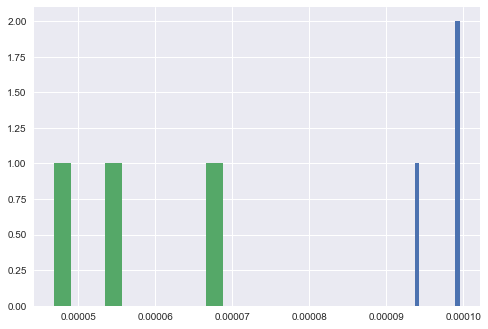

In [12]:
plt.hist(v['fast'])
plt.hist(v['slow'])

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([0.72267613, 0.72838513, 0.73409413, 0.73980313, 0.74551213,
        0.75122113, 0.75693013, 0.76263913, 0.76834813, 0.77405713,
        0.77976613]),
 <a list of 10 Patch objects>)

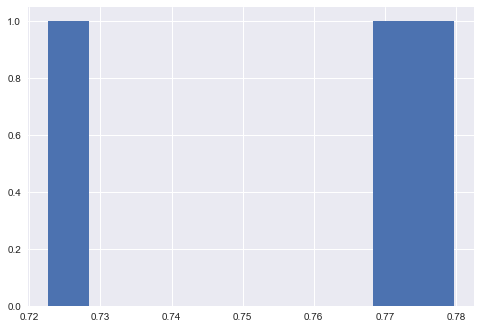

In [13]:
plt.hist(tau)

(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.00810007, 0.00843198, 0.00876388, 0.00909579, 0.0094277 ,
        0.00975961, 0.01009151, 0.01042342, 0.01075533, 0.01108724,
        0.01141915]),
 <a list of 10 Patch objects>)

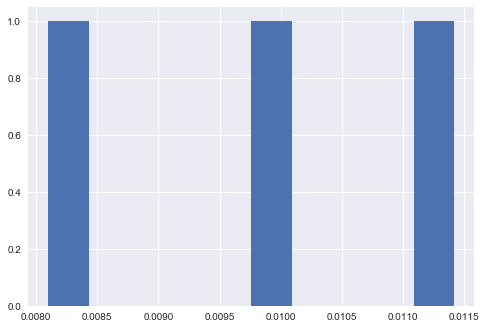

In [14]:
plt.hist(s)

The simulation method currently does not support direct coding of multiple-factor designs. The `condition` variable in the data frame currently codes both factors and therefore needs to be split into two columns:

In [15]:
dependence_model.data['bias'], dependence_model.data['speed'] = dependence_model.data['condition'].str.split('_', 1).str
dependence_model.data.head()

,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition,bias,speed
0,2.0,0.0,1430.0,0.0,0.0,8,0.133815,7,0.430113,8,0.436072,high_fast,high,fast
1,0.0,0.0,1744.0,0.0,1.0,1,0.423586,0,0.394485,5,0.181930,high_fast,high,fast
2,1.0,0.0,1623.0,0.0,2.0,4,0.083598,1,0.845511,5,0.070891,high_fast,high,fast
3,1.0,0.0,1403.0,0.0,3.0,4,0.424859,7,0.349890,6,0.225251,high_fast,high,fast
4,2.0,0.0,1684.0,0.0,4.0,0,0.271260,0,0.386366,9,0.342374,high_fast,high,fast


# Exploring data

Next, we look at the behavioral data, by plotting the data separately for the speed & bias conditions. The aggregate data are plotted in black, whereas condition-specific data are plotted in color.

From left to right, we see: (A) mean response times (in ms), (B) mean probability of choosing the left item as a function of the item's liking rating, (C) mean probability of choosing the left item as a function of the difference between the item's gaze and the mean gaze of all other items, (D) mean probability of choosing the left item as a function of the difference between the item's gaze and the mean gaze of all other items, when corrected for the influence of item rating on choice probability (for further details, see Thomas, Molter, Krajbich, Heekeren & Mohr, 2017).

### Fast & Slow Speed

As expected, the data data of both speed-conditions matchs in all analyses, except for the response times (panel A).

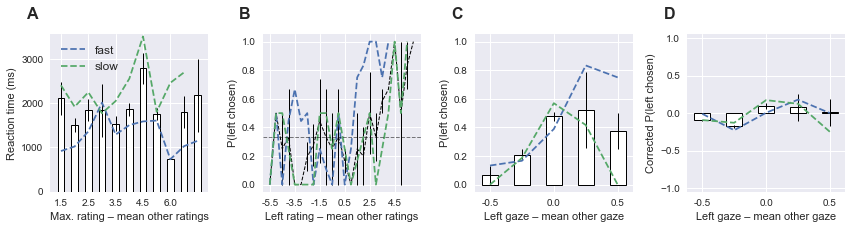

In [16]:
glam.plot_fit(dependence_model.data, [dependence_model.data[dependence_model.data['speed'] == 'fast'],
                                      dependence_model.data[dependence_model.data['speed'] == 'slow']],
              prediction_labels=['fast', 'slow']);

### High & Low Bias

Similarly, the data  in both bias-conditions matches in response times, but differs in all analysis of the gaze bias (C - D). 

Interestingly, there is also a substantial difference between both bias-groups in their probability of choosing an item, given the item's rating value (B). This relationship can be explained as follows: if (1) an individual's choices are strongly dependent on the allocation of gaze during the decision process, and (2) the gaze of the individual is allocated independent of the items' rating values, then the effect of item rating on the individuals' choices can be suppressed by the strong association of gaze and choice. Therefore, we expect individuals to have a lower association of item rating and choice, if their association of gaze and choice is strong and their gaze is distributed independent of item rating.

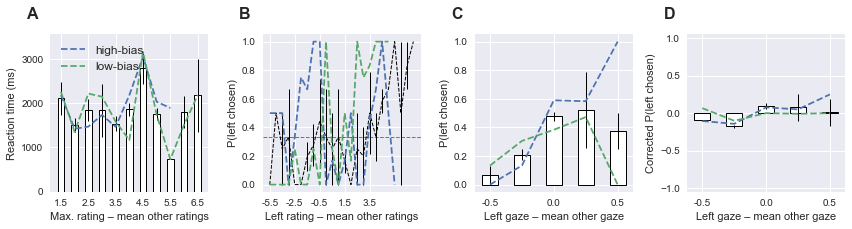

In [17]:
glam.plot_fit(dependence_model.data, [dependence_model.data[dependence_model.data['bias'] == 'high'],
                                      dependence_model.data[dependence_model.data['bias'] == 'low']],
              prediction_labels=['high-bias', 'low-bias']);

# Model fitting

### Model set up

Next, we need to specify the exact model to fit to the data. We need to indicate that the gaze-bias parameter $\gamma$ shall depend on the `bias` condition of our data, and the velocity parameter $v$ on the `speed` condition.

We also have to choose whether we want to fit the model hierarchically to all of our participants, or to each individual participant alone. We choose the individual model here.

In [18]:
# create alternative model that will not have any parameter dependences
import copy
independence_model = copy.copy(dependence_model)

In [19]:
dependence_model.make_model(kind='individual',
                            depends_on=dict(gamma='bias',
                                            v='speed'),
                            t0_val=0) # we did not simulate any non-decision time and therefore fix t0 = 0b

Adding "behavioral_indices" to GLAM.


/Users/armin/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Generating single subject models for 3 subjects...


In [20]:
independence_model.make_model(kind='individual', t0_val=0)

Adding "behavioral_indices" to GLAM.
Generating single subject models for 3 subjects...


### Parameter estimation

The model is specified. Now the parameters can be estimated. `GLAMbox` implements the model as a `pymc3` model object, that can be fit with all fitting procedures included in `pymc3`. For individual models, we recommend the No-U-Turn Sampler (NUTS; XXX).

In [21]:
dependence_model.fit(method='NUTS', n_samples=500)

Fitting 3 model(s) using NUTS...
  Fitting model 1 of 3...


/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:10<00:00, 98.42it/s]
/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


  Fitting model 2 of 3...


100%|██████████| 1000/1000 [00:08<00:00, 112.76it/s]


  Fitting model 3 of 3...


100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s]/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



/!\ Automatically setting parameter precision...


In [22]:
independence_model.fit(method='NUTS', n_samples=500)

Fitting 3 model(s) using NUTS...
  Fitting model 1 of 3...


/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:07<00:00, 140.02it/s]


  Fitting model 2 of 3...


100%|██████████| 1000/1000 [00:11<00:00, 85.84it/s]


  Fitting model 3 of 3...


100%|██████████| 1000/1000 [00:05<00:00, 175.62it/s]


/!\ Automatically setting parameter precision...


# model comparison

In [26]:
ic = 'WAIC'
comparison_result = glam.utils.compare(dependence_model, independence_model, ic=ic)

## Analysis

### Parameter recovery

Now that the model parameters are estimated, we want to test whether the model properly recovered the group-specific condition parameters (i.e. $v$ and $\gamma$). 

.. on individual level

In [ ]:
bins = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()

for i, bias in enumerate(['high', 'low']):
    ax.hist(model.trace['gamma_{}_mu'.format(bias)], bins=bins,
            histtype='stepfilled', alpha=0.5, color='C{}'.format(i),
            label=bias, normed=True)
    
    ax.axvline(gamma[bias].mean(), color='C{}'.format(i))
    
ax.legend(frameon=False)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\gamma$ group means');

Similarly, we see that the model correctly estimates and separates our empricial speed (i.e. $v$) group means.

In [ ]:
bins = np.linspace(0, 0.0002, 100)

fig, ax = plt.subplots()

for i, speed in enumerate(['fast', 'slow']):
    ax.hist(model.trace['v_{}_mu'.format(speed)], bins=bins,
            histtype='stepfilled', alpha=0.5, color='C{}'.format(i),
            label=speed, normed=True)
    
    ax.axvline(v[speed].mean(), color='C{}'.format(i))
    
ax.legend(frameon=False)
ax.set_xlabel(r'$v$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $v$ group means');

In [ ]:
bins = np.linspace(0, 2, 100)

fig, ax = plt.subplots()

ax.hist(model.trace['tau_mu'], bins=bins,
        histtype='stepfilled', alpha=0.5,
        normed=True)

ax.axvline(tau.mean())
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\tau$ group means');

In [ ]:
bins = np.linspace(0, 0.02, 100)

fig, ax = plt.subplots()

ax.hist(model.trace['s_mu'], bins=bins,
        histtype='stepfilled', alpha=0.5,
        normed=True)

ax.axvline(s.mean())

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\sigma$ group means');

### Prediction

Next, we can test the aboslute fit of the estimated model, by simulating response data with our parameter estimates and plotting them against the previously simulated data that was used to estimate the model parameters.

In [ ]:
# for the simulation, we repeat each trial of the original dataset 10 times.
model.predict(n_repeats=10)
model.prediction.head()

### Goodnes of fit

To test the goodness of fit of these predictions, we again plot the predicted data against our original data. This time, separately within each of the 4 conditoins

#### High Bias & Fast Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'fast',
                                        model.data['bias'] == 'high')],
              [model.prediction[np.logical_and(model.prediction['speed'] == 'fast',
                                               model.prediction['bias'] == 'high')]])

#### High Bias & Slow Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'slow',
                                        model.data['bias'] == 'high')],
              [model.prediction[np.logical_and(model.prediction['speed'] == 'slow',
                                               model.prediction['bias'] == 'high')]])

#### Low Bias & Fast Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'fast',
                                        model.data['bias'] == 'low')],
              [model.prediction[np.logical_and(model.prediction['speed'] == 'fast',
                                               model.prediction['bias'] == 'low')]])

#### Low Bias & Slow Speed

In [ ]:
glam.plot_fit(model.data[np.logical_and(model.data['speed'] == 'slow',
                                        model.data['bias'] == 'low')],
              [model.prediction[np.logical_and(model.prediction['speed'] == 'slow',
                                               model.prediction['bias'] == 'low')]])

# References

- Kucukelbir, A., Ranganath, R., Gelman, A., & Blei, D. M. (2015). Automatic Variational Inference in Stan. ArXiv:1506.03431 [Stat]. Retrieved from http://arxiv.org/abs/1506.03431

- Armin W. Thomas & Felix Molter, Ian Krajbich, Hauke R. Heekeren, Peter N. C. Mohr (2017)
bioRxiv 228825; doi: https://doi.org/10.1101/228825